<h1><center>Workflows for Reproducible Research using Containerization</center></h1>
<p><center>Instructors: Jordan Lawson and Paul Cao</center>
 <center>Center for Computation and Visualization</center>
 <center>Center for Computational Biology of Human Disease - Computational Biology Core</center></p>

Resources for help @brown <br> 

COBRE CBHD Computational Biology Core
- Office hours
- https://cbc.brown.edu
- slack channel on ccv-share
- cbc-help@brown.edu <br>

Center for Computation and Visualization
- Office hours
- https://ccv.brown.edu
- ccv-share slack channel
- https://docs.ccv.brown.edu
- support@ccv.brown.edu

## What is Covered in This Tutorial?  

In previous workshops, we went over how to build standardized workflows using Nextflow. In this workshop, we will go over: 

- Strategies for making these workflows reproducible
- How to build or extend a Docker container and run it in a Nextflow pipeline
- A step by step approach to creating a completey reproducible analysis using containers and workflows

## Reproducibility
### What it is and Why it matters
There are philosophical and practical considerations for ensuring that any code/analysis is reproducible. The idea of reproducibility is one of the fundamental tenets of scientific endeavors and will leave it at that.

More recently, the emphasis on reproducibility has gained attention as large scale data generation has grown ubiquitous and data-driven results are becoming more common across the sciences.

Importantly, pratical considertations are becoming more common too nowadays. Questions or statements like:

- This is the dataset from the supplementary material, how can i regenerate the plot?
- A lab member provided this script and it runs fine for that person

## So What exactly are containers
Docker containers are like virtual machines except that they share guest OSs, which makes them very lightweight. However, it’s still useful to think of Docker containers as virtual machines, because they feel like their own self-contained units.
https://erick.matsen.org/2018/04/19/docker.html

In fact, focusing on what is abstracted away by virtual machines and containers can help make containers conceptually "click" for you. In short:

- Virtual machines and hypervisors abstract away hardware and enable you to run operating systems

- Containers (technically container engines) abstract away operating systems and enable you to run applications

https://www.cbtnuggets.com/blog/certifications/cloud/container-v-hypervisor-whats-the-difference


## Approach to a completely reproducible workflow

So for a complete end-to-end analysis of NGS data, there are three  general stages
- Stage1: The first stage of the basic workflow is data acquisition, input, or creation. This stage commonly consists of collecting data from a primary source, such as field observation, experimental research, or surveys. However, it also may include acquiring data from an existing source such as reference genomes and annotations. Regardless of the method, the end result of this first stage is raw data and reference datasets.

- Stage 2: The second stage involves processing of the raw NGS data. Depending on the tools used and the author's strategies, this stage may include tasks such as manual data entry, visual data review, or systematic data manipulation or filtering using scripts or other software. At the completion of this second stage, the relevant data is fully prepared for analysis. This stage primarily involves the workflows


- Stage 3: The third stage is data analysis. The most common form of data analysis is formal statistics, but other activities in this stage include data visualization, assessing the performance of particular algorithms, and extending the data to address a hypothesis or draw a scientific conclusion. The defining attribute of this stage is that it analyzes, in some manner, the clean data produced in the second stage, and produces the desired scientific products of the research, generally quantitative results in the form of figures and tables that are incorporated into manuscripts, talks, and other forms of communication.

To ensure a robust reproducible workflow, all three stages need to be documented and characterized via code as far as possible. 

Usually this can be accomplished by leveraging multiple platforms including github, docker and nextflow. 


## Strategies for Reproducibility using Containerization
The ideal scenario is to be completely portable across infrastructure as outlined
![image.png](attachment:4db130f1-022f-4a24-b59c-385eff27d459.png)

For example we want to be able to have a self contained environment that can be moved to a local machine(laptop/desktop) or a High Performance Cluster  or even to the cloud. 

THIS IS NOW POSSIBLE!!!! No surprises there with the inception of the Open Container Initiative. The OCI helps maintain a set of standards for container runtimes, ensuring interoperability. 

### So what strategies can we use to get there?
There are a few different ways to leverage containerization to make your workflows reproducible and we will discuss and work through this within the context of Nextflow and OSCAR. 
- We can leverage and Use Pre-Built Docker Containers  such as those in `nf-core`
- We can Build our own containers from scratch or modify existing containers

This strategy can be also used to build R-based containers for analysis, as shown in the workshop on Tuesday. Lastly, one other aspect to consider in terms of strategy is how to account for storage limitations. 


#### Leverage and Use Pre-Built Docker Containers in `nf-core`:


We don't have to always build containers from scratch. We can also refer to and draw on the rich repository of `nf-core` or `biocontainers`. For example, we can find the Singularity image url for every process defined in a `nf-core` workflow (they are always stored in `modules/nf-core/$PROCESS`). We will use `bismark` in `nf-core/methylseq` as an example:

##### Find the `bismark` process definition: 


###### https://github.com/nf-core/methylseq/blob/master/modules/nf-core/bismark/align/main.nf:
```bash
process BISMARK_ALIGN {
    container "${ workflow.containerEngine == 'singularity' && !task.ext.singularity_pull_docker_container ?
        'https://depot.galaxyproject.org/singularity/bismark:0.24.0--hdfd78af_0' :
        'quay.io/biocontainers/bismark:0.24.0--hdfd78af_0' }"
    
    """
    bismark \\
        $fastq \\
        --genome $index \\
        --bam \\
        $args
    cat <<-END_VERSIONS > versions.yml
    "${task.process}":
        bismark: \$(echo \$(bismark -v 2>&1) | sed 's/^.*Bismark Version: v//; s/Copyright.*\$//')
    END_VERSIONS
    """
    ...
}
```

##### Copy it into our workflow:

We can simply grab the singularity container url: `'https://depot.galaxyproject.org/singularity/bismark:0.24.0--hdfd78af_0'`

```bash
process BISMARK_ALIGN {
    container 'https://depot.galaxyproject.org/singularity/bismark:0.24.0--hdfd78af_0'

    output:
     stdout

    script:
    """
    bismark
    """
}
```

#### Adapt existing/Build Docker Container

At times it may be necessary to either build your own Docker containers or adapt existing Docker/Singularity containers when running your workflow. The following sections will demonstrate how to build or adapt existing containers into your Nextflow workflow.

##### Build a Docker Container from scratch

Suppose you might like to use an alternative reads aligner, `salmon`; which is not available on OSCAR and so you would like to build a docker container so you can run it on OSCAR. The steps to do so would be as follows: 

##### 3a. First make a `Dockerfile`:
```bash
FROM ubuntu:lunar

RUN apt-get update && apt-get install -y curl cowsay
RUN curl -sSL https://github.com/COMBINE-lab/salmon/releases/download/v1.5.2/salmon-1.5.2_linux_x86_64.tar.gz | tar xz \
&& mv /salmon-*/bin/* /usr/bin/ \
&& mv /salmon-*/lib/* /usr/lib/
```

##### 3b. Build the Docker image (targetting `linux/amd64` for OSCAR and tagged as `salmon:latest`):
Explicitly specifying the Docker build platform of `linux/amd64` is necessary to make your container compatible with OSCAR (a Scientific Linux environment) versus your local environment which may or may not be compatible (e.g., MacOS ARM64 or Windows PC)./

```bash
docker build -f salmon_Dockerfile -t salmon:latest --platform linux/amd64 .
```

##### 3c. Upload to your DockerHub account:
Uploading your Docker container to the cloud then enables Nextflow running on OSCAR to pull down your container from `Dockerhub` or other container registries and use them. 

```bash
docker tag salmon:latest $DOCKER_USER/salmon:latest
docker push $DOCKER_USER/salmon:latest
```

##### 3c. Alternative copy the image directly

```bash
docker save <image_id> | gzip  - > test_salmon.tgz
scp test_salmon.tgz aragaven@ssh.ccv.brown.edu:/oscar/scratch/aragaven/test_repr_2024/
```
Then we can login to OSCAR and use the image locally after converting it to an apptainer image

```
apptainer build test_salmon.sif docker-archive:/oscar/scratch/aragaven/test_repr_2024/test_salmon.tgz
```

###### 3d. Reference your container with its `DockerHub` id and tag in workflow
This will instruct the Nextflow pipeline to automatically pull down your Docker container and convert them into a Singularity image (which is a safer/more compatible container that `OSCAR` prefers to run):


###### salmon.nf:
```bash
process salmon {
    container 'cowmoo/salmon:latest'

    output:
     stdout

    script:
    """
    salmon -h
    """
}

workflow {
  salmon() | view
}
```

###### run salmon.nf:

```bash
nextflow run salmon.nf
```

##### Adapt Docker Container 
We can easily build a docker container and add to it saving us the time for figuring out all the installation steps. For example to add `salmon` to the `bismark` container, we would modify the dockerfile as follows
```
FROM quay.io/biocontainers/bismark:0.24.0--hdfd78af_0

RUN wget https://github.com/COMBINE-lab/salmon/releases/download/v1.5.2/salmon-1.5.2_linux_x86_64.tar.gz | tar xz \
&& mv /salmon-*/bin/* /usr/bin/ \
&& mv /salmon-*/lib/* /usr/lib/
```

Note that I am using wget instead of CURL. The reason is because the `quay.io` container is built on top of busybox a minimal container and this does not have tools like apt. There are two strategies to overcome this
- change the retreival method
- find a container built on a more standard OS like ubuntu that contains all the tools you need
- Find the Dockerfile and use the commands to rebuild the container on Ubuntu


## Putting it all together

Let's take a look at a standard RNASeq workflow that's pretty complete and exhaustive and work through the stages and how we would use nextflow, github,R and containers

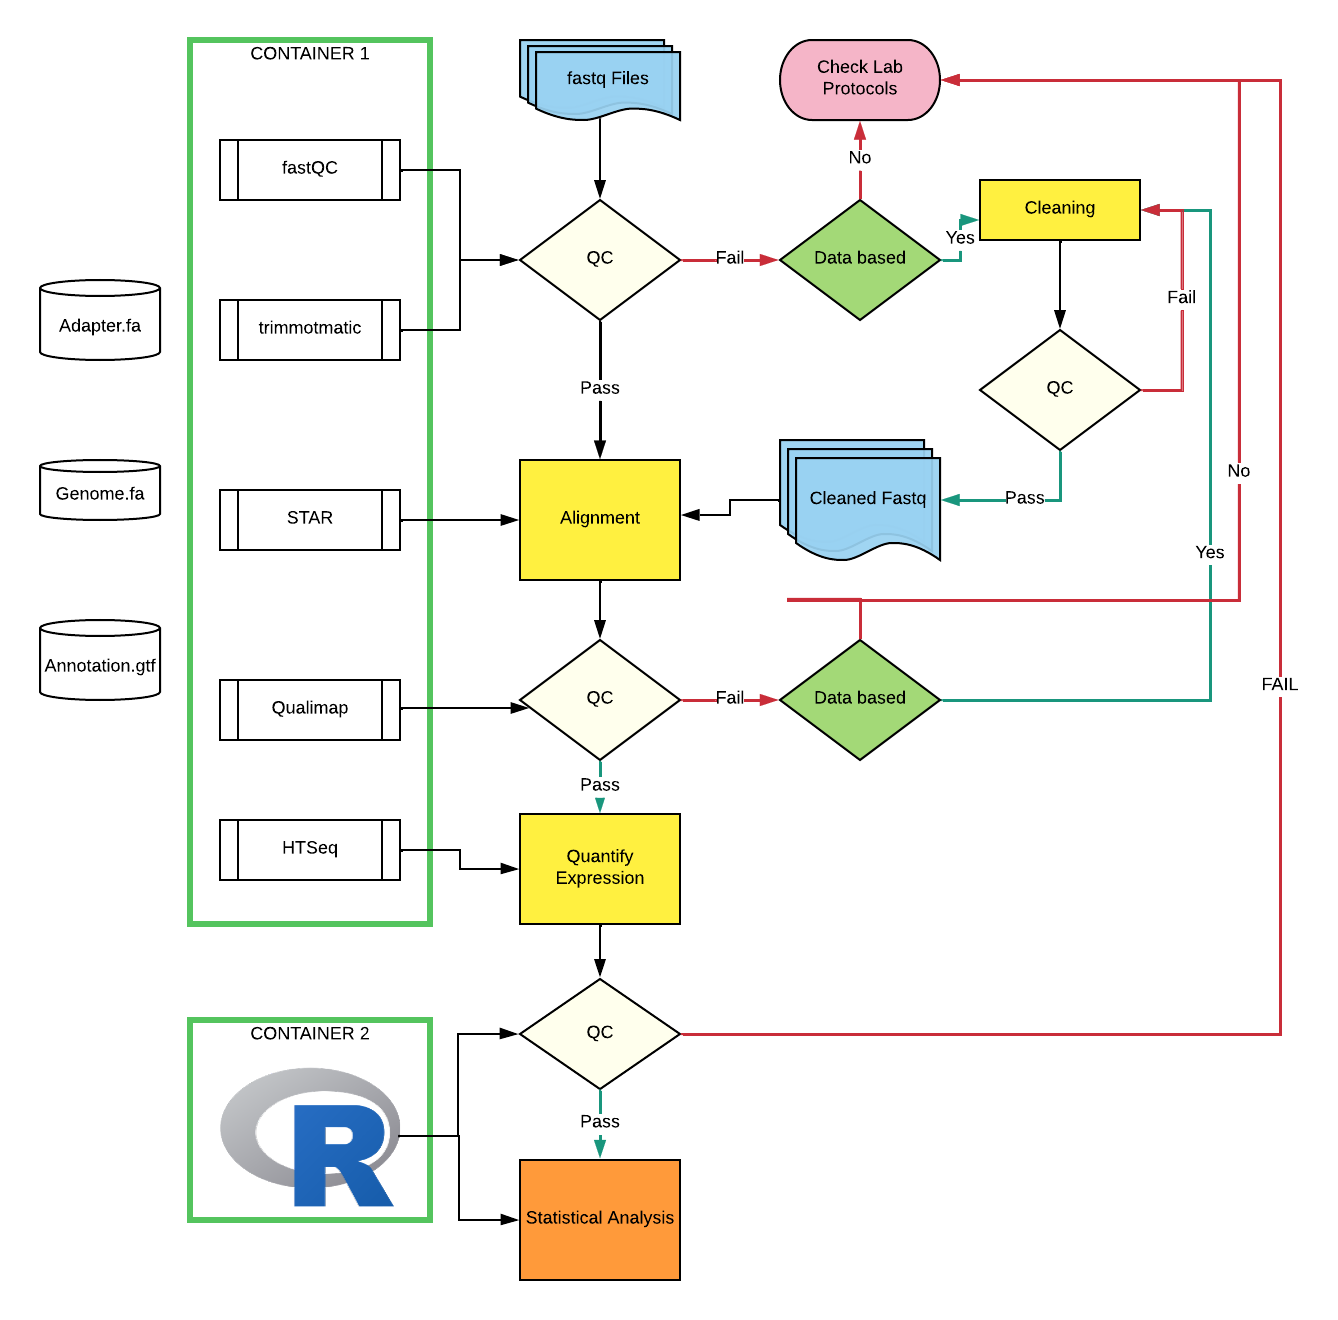


### Stage 1
In this workflow the data artifacts that we have to create are the references for the workflow, namely
- the Adapter references for trimmomatic
- the genome reference for alignment
- the GTF reference for annotation

Generally, it is not recommended to store large files in the container such as the Genome reference which may be a few GB. However if they are small enough it might be optimal to store in the container
- So for the Adapter.fa files it might be optimal to store it in the container directly
- for the Genome.fa and GTF files one would use local disk space and pass the parameters to nextflow.

For reproducibility, one would create a script in bash or python that has automates the entire process of downloading the local files and any processing such as index creation etc and copy it into the container. let's say we have made a script called `generate_refs.sh` then we can modify the Dockerfile as

```
FROM ubuntu:lunar

RUN apt-get update && apt-get install -y curl cowsay
RUN curl -sSL https://github.com/COMBINE-lab/salmon/releases/download/v1.5.2/salmon-1.5.2_linux_x86_64.tar.gz | tar xz \
&& mv /salmon-*/bin/* /usr/bin/ \
&& mv /salmon-*/lib/* /usr/lib/
COPY generate_ref.sh /opt/scripts/generate_refs.sh

```

### Stage 2 

This is where we would now go ahead and modify/build the container to include all the necessary tools for running the bioinformatics processing part of the workflows. At this stage you mainly want to ensure that all the programs are installed in your container and are available for use. 


### Stage 3

In this stage, there needs to be a decision made as to whether to maintain a single container or separate container. This will be determined by two factors
- How simple/complicated the install process is
- The resulting size of the container

Given that most of the data analysis with NGS datasets proceeds with R, we usually opt to build a separate container for the data analyis sections. The main reason for this is because installation of the GUI components of R such as RStudio is non-trivial and we can leverage base containers provided by the Rocker community to install our own specific set of packages for the analysis.
